In [ ]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [ ]:
!gcloud auth application-default login --scopes=https://www.googleapis.com/auth/cloud-platform


You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=cZgk8S2Z4wv9bNawBirNPFQ79pYUyu&prompt=consent&access_type=offline&code_challenge=34CZ3q5syc60PmwpBxTW1IXsdDcFNqULHb6uALkUJTQ&code_challenge_method=S256

Enter authorization code: 4/0AfJohXkOKYE9WgctLVMpp2xr45G

# Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout,Dense, Input, Masking, GlobalAveragePooling1D, Embedding, Lambda, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Huber


In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)


Tensorflow version 2.12.0
Running on TPU  ['10.36.241.18:8470']


# Parsing and Filtering Feature Set

In [3]:
full_feature_list = sorted(['week_day', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_30', 'SMA_40', 'EMA_10', 'EMA_30', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_10', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'avgTradingVolume', 'ADX_14', 'DMP_14', 'DMN_14', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'PSAR_combined', '52_week_high', '52_week_low', 'NASDAQ_Close', 'NASDAQ_EMA_10', 'NASDAQ_EMA_30', 'SP500_Close', 'SP500_EMA_10', 'SP500_EMA_30'])

features_to_keep = ['week_day', 'Open', 'High', 'Low', 'Close', 'Volume','SMA_30', 'SMA_40', 'EMA_10', 'EMA_30', 'MACDh_12_26_9', 'RSI_10', 'BBP_5_2.0', 'avgTradingVolume', 'STOCHk_14_3_3', '52_week_high', '52_week_low', 'NASDAQ_Close', 'STOCHd_14_3_3', 'ADX_14', 'DMP_14', 'DMN_14', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'PSAR_combined']

feature_list = sorted([feature for feature in full_feature_list if feature in features_to_keep])

In [4]:
def parse_tfrecord_fn(example_proto, feature_list):
    # Define the feature description
    feature_description = {}
    num_days = 30

    for day in range(num_days):
        for feature in feature_list:
            feature_key = f"{feature}_{day}"
            feature_description[feature_key] = tf.io.FixedLenFeature([], tf.float32)

    feature_description['label'] = tf.io.FixedLenFeature([], tf.float32)

    # Parse the input `tf.train.Example` proto
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Extract and reshape features
    features = [parsed_features[f"{feature}_{day}"] for day in range(num_days) for feature in feature_list]
    features_tensor = tf.reshape(tf.stack(features), (num_days, len(feature_list)))


    # Extract label
    label = parsed_features['label']

    # Assuming 'open_price' is the name of the opening price feature
    # Adjust 'open_price_key' to match how your features are named
    open_price_key = f"SMA_30_{num_days - 1}"  # The opening price on the last day of the sequence
    last_day_opening_price = parsed_features[open_price_key]

    # Create a tuple for the label
    label_tensor = tf.stack([last_day_opening_price, label], axis=0)

    return features_tensor, label_tensor


batch_size = 256  # You can adjust this size


In [ ]:
num_days = 20
# Label is same as features for autoencoder
def parse_tfrecord_fn_autoenc(example_proto, feature_list):
    # Define the feature description
    feature_description = {}

    for day in range(num_days):
        for feature in feature_list:
            feature_key = f"{feature}_{day}"
            feature_description[feature_key] = tf.io.FixedLenFeature([], tf.float32)

    feature_description['label'] = tf.io.FixedLenFeature([], tf.float32)

    # Parse the input `tf.train.Example` proto
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Extract and reshape features
    features = [parsed_features[f"{feature}_{day}"] for day in range(num_days) for feature in feature_list]
    features_tensor = tf.reshape(tf.stack(features), (num_days, len(feature_list)))


    # Extract label
    label = parsed_features['label']

    return features_tensor, features_tensor


batch_size = 256  # You can adjust this size

In [ ]:
def test_tfrecord_parsing(tfrecord_path, timestep_to_print=0):
    # Load one example from the TFRecord
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    for raw_record in raw_dataset.take(1):
        features_tensor, label = parse_tfrecord_fn(raw_record, feature_list)

        # Print the specified timestep and its features
        print(f"Label: {label.numpy()}")
        print(f"Features at timestep {timestep_to_print}:")
        for index, feature in enumerate(feature_list):
            print(f"  Feature {feature}: {features_tensor[timestep_to_print, index].numpy()}")

# Example usage
tfrecord_path = 'gs://trendformer/Datasets/10_features/with_names/training_data.tfrecord'
test_tfrecord_parsing(tfrecord_path, timestep_to_print=2)

In [5]:
def print_example():
    num_days = 30
    for features_tensor, label_tuple in train_dataset.take(1):
        # Convert the tensor to numpy array
        features_array = features_tensor.numpy()
        last_day_open_price, next_day_open_price = label_tuple

        # Convert tuple elements to numpy if they are tensors
        last_day_open_price = last_day_open_price.numpy() if hasattr(last_day_open_price, 'numpy') else last_day_open_price
        next_day_open_price = next_day_open_price.numpy() if hasattr(next_day_open_price, 'numpy') else next_day_open_price

        # Print the features for each day
        for day in range(num_days):
            print(f"Day {day + 1} features:")
            for feature_index, feature_name in enumerate(feature_list):
                feature_value = features_array[day, feature_index]
                print(f"  {feature_name}: {feature_value}")

        # Print the label tuple
        print(f"Last Day Opening Price: {last_day_open_price}")
        print(f"Next Day Opening Price: {next_day_open_price}")


# Loading Training Examples

In [6]:
train_tfrecord_path = 'gs://trendformer/Datasets/2014_tech_ind_30_days/training_data.tfrecord'
val_tfrecord_path = 'gs://trendformer/Datasets/2014_tech_ind_30_days/validation_data.tfrecord'
train_dataset = tf.data.TFRecordDataset(train_tfrecord_path).map(lambda example: parse_tfrecord_fn(example, feature_list))
val_dataset = tf.data.TFRecordDataset(val_tfrecord_path).map(lambda example: parse_tfrecord_fn(example, feature_list))

In [7]:
print_example()

Day 1 features:
  52_week_high: -0.4418921172618866
  52_week_low: -0.5315368175506592
  ADX_14: 0.8193331956863403
  BBP_5_2.0: 0.058229826390743256
  Close: -0.3957943320274353
  DMN_14: -0.36235305666923523
  DMP_14: 0.411251038312912
  EMA_10: -0.39402151107788086
  EMA_30: -0.4047515392303467
  High: -0.39331966638565063
  IKS_26: -0.4108714461326599
  ISA_9: -0.4196344316005707
  ISB_26: -0.4511941969394684
  ITS_9: -0.3923180401325226
  Low: -0.39574527740478516
  MACDh_12_26_9: -0.26621168851852417
  NASDAQ_Close: -1.2656017541885376
  Open: -0.40017664432525635
  PSAR_combined: -0.4139421880245209
  RSI_10: -0.019008368253707886
  SMA_30: -0.4047476053237915
  SMA_40: -0.4101608693599701
  STOCHd_14_3_3: -0.8268398642539978
  STOCHk_14_3_3: -1.0582871437072754
  Volume: -0.5941662192344666
  avgTradingVolume: -0.3894733488559723
  week_day: 0.6986939311027527
Day 2 features:
  52_week_high: -0.4418921172618866
  52_week_low: -0.5315368175506592
  ADX_14: 0.7967161536216736
  B

Exception ignored in: <function Executor.__del__ at 0x7e606c18d3f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


  MACDh_12_26_9: 0.27644211053848267
  NASDAQ_Close: -1.302532434463501
  Open: -0.2669159770011902
  PSAR_combined: -0.31878507137298584
  RSI_10: 1.6351985931396484
  SMA_30: -0.33377525210380554
  SMA_40: -0.34652814269065857
  STOCHd_14_3_3: 1.3063628673553467
  STOCHk_14_3_3: 1.2666151523590088
  Volume: -0.447142630815506
  avgTradingVolume: -0.2847043573856354
  week_day: -0.016775764524936676
Day 25 features:
  52_week_high: -0.34049150347709656
  52_week_low: -0.5315368175506592
  ADX_14: 2.0646331310272217
  BBP_5_2.0: 1.4680041074752808
  Close: -0.2541733384132385
  DMN_14: -1.3890210390090942
  DMP_14: 1.617854118347168
  EMA_10: -0.2776132822036743
  EMA_30: -0.31905800104141235
  High: -0.25672170519828796
  IKS_26: -0.326614111661911
  ISA_9: -0.39766138792037964
  ISB_26: -0.4144188165664673
  ITS_9: -0.29679590463638306
  Low: -0.26214608550071716
  MACDh_12_26_9: 0.2626602351665497
  NASDAQ_Close: -1.2897363901138306
  Open: -0.26859134435653687
  PSAR_combined: -0.3

In [8]:
train_dataset = train_dataset.shuffle(buffer_size=100000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
autoencoder_train_dataset = tf.data.TFRecordDataset(train_tfrecord_path).map(lambda example: parse_tfrecord_fn_autoenc(example, feature_list))
autoencoder_val_dataset = tf.data.TFRecordDataset(val_tfrecord_path).map(lambda example: parse_tfrecord_fn_autoenc(example, feature_list))

autoencoder_train_dataset = autoencoder_train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
autoencoder_val_dataset = autoencoder_val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Autoencoder Model Definition

In [ ]:
with tpu_strategy.scope():
  def create_recurrent_autoencoder(timesteps, n_features, latent_dim, lstm_units):
    """
    Creates a recurrent autoencoder (RAE).

    Parameters:
    timesteps (int): Length of the input sequences.
    n_features (int): Number of features for each timestep.
    latent_dim (int): Dimensionality of the encoding space.
    lstm_units (int): Number of LSTM units.

    Returns:
    autoencoder (Model): The RAE model.
    encoder (Model): The encoder part of the RAE.
    """

    # Define the encoder
    encoder_inputs = Input(shape=(timesteps, n_features))
    encoded = LSTM(lstm_units, return_sequences=False)(encoder_inputs)
    # This Dense layer sets the latent dimension
    encoded = Dense(latent_dim, activation='relu')(encoded)
    encoded = RepeatVector(timesteps)(encoded)

    # Define the decoder
    decoder_lstm = LSTM(lstm_units, return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(n_features))(decoder_lstm)

    # Define the autoencoder model
    autoencoder = Model(encoder_inputs, decoded)

    # Define the encoder model
    encoder = Model(encoder_inputs, encoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder

  # Set the RAE parameters
  timesteps = 20  # Length of input sequences
  n_features = 10  # Number of features in your dataset, adjust accordingly
  latent_dim = 64  # Dimensionality of the encoding space
  lstm_units = 128  # Number of LSTM units

  # Create the RAE and encoder models
  autoencoder_model, encoder_model = create_recurrent_autoencoder(timesteps, n_features, latent_dim, lstm_units)

  # Print the autoencoder summary
  autoencoder_model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_182 (InputLayer)      [(None, 20, 10)]          0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               71168     
                                                                 
 dense_238 (Dense)           (None, 64)                8256      
                                                                 
 repeat_vector_9 (RepeatVect  (None, 20, 64)           0         
 or)                                                             
                                                                 
 lstm_19 (LSTM)              (None, 20, 128)           98816     
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 10)           1290      
 tributed)                                                

In [ ]:
epochs = 30

history = autoencoder_model.fit(
    autoencoder_train_dataset,
    epochs=epochs,
    validation_data=autoencoder_val_dataset,
    verbose=1
)

# Prediction Model Definition

In [12]:
# Define the Transformer's parameters
d_model = 512  # Embedding dimension

num_heads = 8  # Number of attention heads
dff = 1024  # Dimension of the feed-forward network
num_layers = 6  # Number of encoder and decoder layers
dropout_rate = 0.1  # Dropout rate

# Constant learning rate
constant_learning_rate = 1e-5

# [32, 20, x]
seq_length = 30  # Length of your input sequences
feature_size = len(feature_list)  # Number of features in your dataset

with tpu_strategy.scope():

  def custom_loss(y_true, y_pred):
    next_day_open_price = tf.expand_dims(y_true[:, 1], axis=-1)

    return tf.keras.losses.mean_squared_error(next_day_open_price, y_pred)


  def directional_accuracy(y_true, y_pred):
    last_day_opening_price = tf.expand_dims(y_true[:, 0], axis=-1)
    next_day_open_price = tf.expand_dims(y_true[:, 1], axis=-1)

    sign_true = K.sign(next_day_open_price - last_day_opening_price)
    sign_pred = K.sign(y_pred - last_day_opening_price)

    return K.mean(K.equal(sign_true, sign_pred), axis=-1)

  def positional_encoding(seq_length, num_features):
      """
      Create positional encodings for the input.

      Parameters:
      seq_length (int): The length of the sequence.
      num_features (int): The number of features being encoded.

      Returns:
      np.ndarray: A seq_length x num_features array of positional encodings.
      """

      # Initialize the positional encoding matrix
      position = np.arange(seq_length)[:, np.newaxis]
      div_term = np.exp(np.arange(0, num_features, 2) * -(np.log(10000.0) / num_features))

      # Compute the positional encodings
      pe = np.zeros((seq_length, num_features))
      pe[:, 0::2] = np.sin(position * div_term)
      pe[:, 1::2] = np.cos(position * div_term)

      return pe

  def transformer_encoder_layer(d_model, num_heads, dff, dropout_rate, name):
      inputs = Input(shape=(None, d_model))
      attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
      attention = Dropout(dropout_rate)(attention)
      attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

      outputs = Dense(dff, activation='relu')(attention)
      outputs = Dense(d_model)(outputs)
      outputs = Dropout(dropout_rate)(outputs)
      outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)

      return Model(inputs=inputs, outputs=outputs, name=name)

  def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, name):
      inputs = Input(shape=(None, d_model))
      enc_outputs = Input(shape=(None, d_model))

      # Create a look-ahead mask for masked self-attention
      seq_length = tf.shape(inputs)[1]
      look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)

      attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs, attention_mask=look_ahead_mask)
      attention1 = Dropout(dropout_rate)(attention1)
      attention1 = LayerNormalization(epsilon=1e-6)(attention1 + inputs)

      attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(attention1, enc_outputs)
      attention2 = Dropout(dropout_rate)(attention2)
      attention2 = LayerNormalization(epsilon=1e-6)(attention2 + attention1)

      outputs = Dense(dff, activation='relu')(attention2)
      outputs = Dense(d_model)(outputs)
      outputs = Dropout(dropout_rate)(outputs)
      outputs = LayerNormalization(epsilon=1e-6)(outputs + attention2)

      return Model(inputs=[inputs, enc_outputs], outputs=outputs, name=name)

  def transformer_model(seq_length, feature_size, d_model, num_heads, dff, num_layers, dropout_rate):
      inputs = Input(shape=(seq_length, feature_size))

      # Ensure that the encoder model is not trainable
      # encoder_model.trainable = False

      # Extracting the open prices and applying positional encoding
      open_prices = inputs[:, :, 21:22]  # Assuming 0-based indexing, the 11th feature is at index 10
      open_prices_pos_encoding = positional_encoding(seq_length, d_model)
      open_prices += open_prices_pos_encoding

      # feature_embeddings = encoder_model(inputs)
      feature_embeddings = Dense(d_model, activation='leaky_relu')(inputs)
      # feature_embeddings = LayerNormalization(epsilon=1e-6)(feature_embeddings)
      pos_encoding = positional_encoding(seq_length, d_model)
      feature_embeddings += pos_encoding

      x = feature_embeddings
      for i in range(num_layers):
          x = transformer_encoder_layer(d_model, num_heads, dff, dropout_rate, f"encoder_layer_{i+1}")(x)

      encoder_output = x

      # Preparing the decoder inputs by expanding the dimensions of the open prices to match the encoder output
      decoder_output = open_prices
      # Passing the combined inputs through the decoder layers
      for i in range(num_layers):
        decoder_output = transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, f"decoder_layer_{i+1}")([decoder_output, encoder_output])

      decoder_output = Lambda(lambda x: x[:, -1, :])(decoder_output)

      outputs = Dense(1, activation='linear')(decoder_output)

      model = Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=constant_learning_rate),
                    loss=custom_loss,
                    metrics=[directional_accuracy])
      # metrics=[directional_accuracy, tf.keras.metrics.MeanSquaredError(name="MSE"), tf.keras.metrics.MeanAbsoluteError(name="MAE"), tf.keras.metrics.MeanAbsolutePercentageError(name="MAPE")])
      return model

  # Create the model
  model = transformer_model(seq_length, feature_size, d_model, num_heads,
                                  dff, num_layers, dropout_rate)

  # Print the model summary to verify the unique naming
  model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 30, 27)]     0           []                               
                                                                                                  
 dense_52 (Dense)               (None, 30, 512)      14336       ['input_39[0][0]']               
                                                                                                  
 tf.__operators__.add_65 (TFOpL  (None, 30, 512)     0           ['dense_52[0][0]']               
 ambda)                                                                                           
                                                                                                  
 encoder_layer_1 (Functional)   (None, None, 512)    9453568     ['tf.__operators__.add_65[0

# Fitting Model

In [ ]:
epochs = 50

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/50
210/210 [==============================] - 182s 291ms/step - loss: 0.2838 - directional_accuracy: 0.5014 - val_loss: 0.0282 - val_directional_accuracy: 0.5584
Epoch 2/50
210/210 [==============================] - 47s 208ms/step - loss: 0.0716 - directional_accuracy: 0.5062 - val_loss: 0.0098 - val_directional_accuracy: 0.5746
Epoch 3/50
210/210 [==============================] - 46s 202ms/step - loss: 0.0439 - directional_accuracy: 0.5075 - val_loss: 0.0079 - val_directional_accuracy: 0.5814
Epoch 4/50
210/210 [==============================] - 46s 203ms/step - loss: 0.0302 - directional_accuracy: 0.5093 - val_loss: 0.0130 - val_directional_accuracy: 0.5822
Epoch 5/50


# Analysis

In [ ]:
# Evaluate the model on the entire validation dataset
evaluation_results = model.evaluate(val_dataset, verbose=0)

# Loop through the results and print them
for i, metric_name in enumerate(model.metrics_names):
    print(f"Validation {metric_name}: {evaluation_results[i]}")

# Sample a subset of the validation dataset
num_samples_to_inspect = 1000
sampled_val_dataset = val_dataset.take(num_samples_to_inspect)

y_val_true = []
y_val_pred = []
last_day_open_prices = []

# Iterate over the sampled validation dataset
for x_batch_val, y_batch_val in sampled_val_dataset:
    # Store the true labels
    y_val_true.extend(y_batch_val.numpy())

    # Predict the batch and store the predictions
    batch_pred = model.predict(x_batch_val)
    y_val_pred.extend(batch_pred)

    # Store the opening prices of the last day in the input sequence
    last_day_open_prices.extend(x_batch_val.numpy()[:, -1, 20])

# Convert the lists to numpy arrays for easier handling
y_val_true = np.array(y_val_true)
y_val_pred = np.array(y_val_pred)
last_day_open_prices = np.array(last_day_open_prices)

yes = 0

up = 0
down = 0

# Print a detailed example-by-example analysis
for i in range(num_samples_to_inspect):
    # Print the last day of the input batch
    print(f"Sample {i+1}:")
    print(f"Opening price of the last day in the input sequence Sanity check X: {last_day_open_prices[i]}")
    print(f"Opening price of the last day in the input sequence: {y_val_true[i][0]}")

    # Print the Y label
    print(f"True Y label: {y_val_true[i][1]}")

    # Print the predicted label
    print(f"Predicted Y label: {y_val_pred[i]}")



    # Calculate and print whether the predicted label followed the same direction as the Y label
    actual_direction = 'Up' if y_val_true[i][1] > y_val_true[i][0] else 'Down'
    predicted_direction = 'Up' if y_val_pred[i] > y_val_true[i][0] else 'Down'
    correct_prediction = actual_direction == predicted_direction

    if actual_direction == 'Up':
      up += 1
    else:
      down += 1

    if correct_prediction:
      yes += 1

    print(f"Up Count: {up}, Down Count: {down}")
    print(f"Did the prediction follow the actual direction? {'Yes' if correct_prediction else 'No'}")
    print(f"Total correct: {yes}")
    print("---")

Validation loss: 0.03930286690592766
Validation directional_accuracy: 0.650333821773529
1/1 [==============================] - 1s 697ms/step


Exception ignored in: <function Executor.__del__ at 0x7f55a1781480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Streaming output truncated to the last 5000 lines.
Predicted Y label: [1.6341963]
Up Count: 180, Down Count: 265
Did the prediction follow the actual direction? Yes
Total correct: 262
---
Sample 446:
Opening price of the last day in the input sequence Sanity check X: 1.5566916465759277
Opening price of the last day in the input sequence: 1.5566916465759277
True Y label: 1.6021958589553833
Predicted Y label: [1.7011354]
Up Count: 181, Down Count: 265
Did the prediction follow the actual direction? Yes
Total correct: 263
---
Sample 447:
Opening price of the last day in the input sequence Sanity check X: 1.5630688667297363
Opening price of the last day in the input sequence: 1.5630688667297363
True Y label: 1.6047933101654053
Predicted Y label: [1.7462821]
Up Count: 182, Down Count: 265
Did the prediction follow the actual direction? Yes
Total correct: 264
---
Sample 448:
Opening price of the last day in the input sequence Sanity check X: 1.5663670301437378
Opening price of the last day i

In [ ]:
# Function to print the results for each epoch
def print_history_stats(history):
    for epoch, stats in enumerate(zip(history.history['loss'], history.history['directional_accuracy'], history.history['val_loss'], history.history['val_directional_accuracy']), start=1):
        train_loss, train_da, val_loss, val_da = stats
        print(f"Epoch {epoch}:")
        print(f"    Training:   Loss: {train_loss:.4f}, directional_accuracy: {train_da:.4f}")
        print(f"    Validation: Loss: {val_loss:.4f}, directional_accuracy: {val_da:.4f}\n")

# Call the function with the history object
print_history_stats(history)

Epoch 1:
    Training:   Loss: 0.2164, directional_accuracy: 0.5090
    Validation: Loss: 0.0346, directional_accuracy: 0.5971

Epoch 2:
    Training:   Loss: 0.0882, directional_accuracy: 0.5192
    Validation: Loss: 0.0389, directional_accuracy: 0.5567

Epoch 3:
    Training:   Loss: 0.0576, directional_accuracy: 0.5223
    Validation: Loss: 0.0152, directional_accuracy: 0.6229

Epoch 4:
    Training:   Loss: 0.0420, directional_accuracy: 0.5279
    Validation: Loss: 0.0145, directional_accuracy: 0.6305

Epoch 5:
    Training:   Loss: 0.0326, directional_accuracy: 0.5355
    Validation: Loss: 0.0185, directional_accuracy: 0.6057

Epoch 6:
    Training:   Loss: 0.0268, directional_accuracy: 0.5362
    Validation: Loss: 0.0129, directional_accuracy: 0.6827

Epoch 7:
    Training:   Loss: 0.0221, directional_accuracy: 0.5439
    Validation: Loss: 0.0147, directional_accuracy: 0.6875

Epoch 8:
    Training:   Loss: 0.0191, directional_accuracy: 0.5446
    Validation: Loss: 0.0107, direct

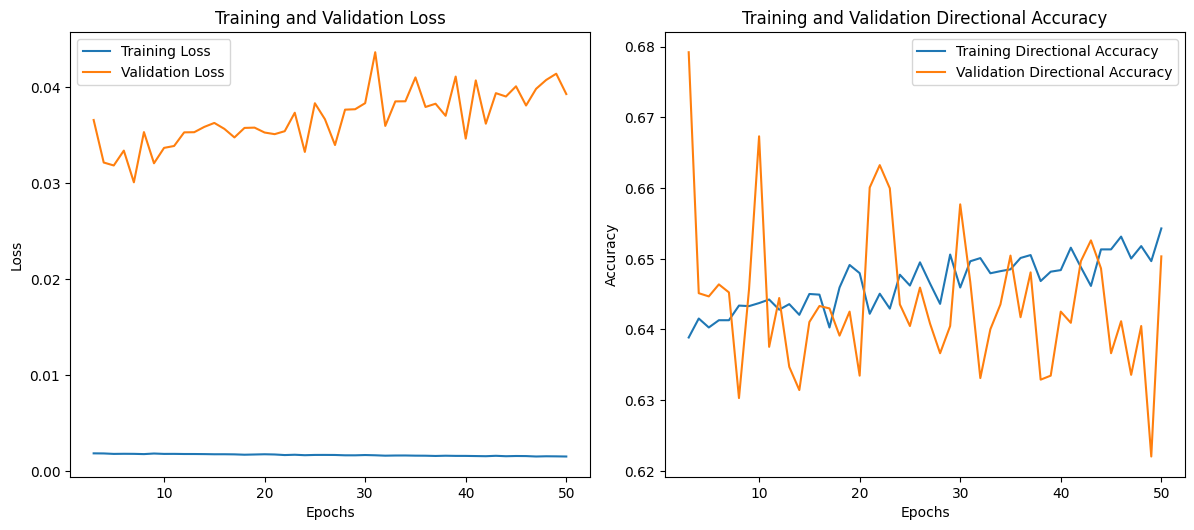

In [ ]:
metrics = history.history

# Adjust epochs range to start from the 6th epoch
start_epoch = 3
epochs = range(start_epoch, len(metrics['loss']) + 1)

plt.figure(figsize=(18, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, metrics['loss'][start_epoch - 1:], label='Training Loss')
plt.plot(epochs, metrics['val_loss'][start_epoch - 1:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Directional Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, metrics['directional_accuracy'][start_epoch - 1:], label='Training Directional Accuracy')
plt.plot(epochs, metrics['val_directional_accuracy'][start_epoch - 1:], label='Validation Directional Accuracy')
plt.title('Training and Validation Directional Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save_weights('model_weights.h5')